In [1]:
from tdc.multi_pred import DrugRes
import sys
import torch
import numpy as np
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from rdkit import Chem
from tqdm import tqdm

# include required directories for relative imports
parent_dir = 'D:\\My Documents\\projects\\drug\\'
sys.path.append(parent_dir)
sys.path.append(parent_dir+"st\\smiles_transformer")

from st.smiles_transformer.utils import split as split_method
from st.smiles_transformer.build_vocab import WordVocab

data = DrugRes(name = 'GDSC1') 
split = data.get_split()
print((data.get_gene_symbols()))

seq_len = 256

vocab = WordVocab.load_vocab(parent_dir+'st\smiles_transformer\data\chembl_vocab.pkl')



Downloading...
100%|███████████████████████████████████████████████████████████████████████████████| 140M/140M [07:06<00:00, 330kiB/s]
Loading...
Done!
Downloading...
100%|███████████████████████████████████████████████████████████████████████████████| 149k/149k [00:00<00:00, 437kiB/s]
Loading...


['TSPAN6' 'TNMD' 'DPM1' ... 'UBL5P2' 'TBC1D3P5' nan]


In [2]:
df = split['train']
print(len(df))
# This is important as the dataset is very structured, without shuffling the training will not work.
df_drug = df.sample(100000, random_state=33)
print(len(df_drug))
print(df.head())
print(len(df['Cell Line'].iloc[1]))

124117
100000
     Drug_ID                                               Drug Cell Line_ID  \
0  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...          ES3   
1  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...          ES5   
2  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...          ES7   
3  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...        EW-11   
4  Erlotinib  COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...      SK-ES-1   

                                           Cell Line         Y  
0  [8.690197905033282, 3.0914731119366, 9.9924871...  3.140923  
1  [8.233101127037282, 2.82468731112752, 10.01588...  3.968757  
2  [8.33346622426757, 3.9667571228514302, 9.79399...  2.692768  
3  [8.39134072442845, 2.9683601858810698, 10.2606...  2.478678  
4  [7.87618818572121, 2.8485457282491, 9.28592458...  2.034050  
17737


In [3]:
df_eval = split['test']
print(len(df_eval))
# This was important as the dataset is very structured!
df_eval = df_eval.sample(10000, random_state=33)


35462


In [4]:
from rdkit import Chem
import numpy as np
from torch.utils.data import Dataset, DataLoader
from response.DrugRespDataset import DrugRespDataset


In [5]:
df_drug['Len'] = df_drug['Drug'].apply(lambda x: len(list(x)))
# Drop rows where the length of the smiles string is longer than 250
df_drug = df_drug[df_drug['Len'] <= seq_len - 8]
train_data = DrugRespDataset(list(df_drug['Drug']),np.array(list(df_drug['Cell Line']), dtype=np.float16), list(df_drug['Y']), vocab, randomize=False, seq_len=seq_len)
train_sampler = RandomSampler(train_data)

train_batch_size=128
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size, drop_last=True)

df_eval['Len'] = df_eval['Drug'].apply(lambda x: len(list(x)))
# Drop rows where the length of the smiles string is longer than 250
df_eval = df_eval[df_eval['Len'] <= seq_len - 8]
eval_data = DrugRespDataset(list(df_eval['Drug']),list(df_eval['Cell Line']), list(df_eval['Y']), vocab, randomize=False,seq_len = seq_len)
eval_sampler = SequentialSampler(eval_data)
eval_batch_size=16
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size, drop_last=True) 

99477 <class 'list'>
9945 <class 'list'>


In [9]:
# Instantiate the model
import torch.nn as nn
from response.DeepPerDrug import PersonalizedDrugResModel
m = PersonalizedDrugResModel(len(vocab.stoi), embed_dim=64, seq_len = seq_len, numRNA_features=17737,mRNA_proj_dim=512, dropout=0.75) 
total_params = sum(p.numel() for p in m.parameters())
print(f"Number of parameters: {total_params/1e6}")
m = m.cuda()

Number of parameters: 10.954193


In [10]:

# Setup loss and eval function
loss = torch.nn.MSELoss().cuda()
lr = 0.0001
optimizer = torch.optim.Adam(m.parameters(), lr=lr)

def eval_model(m, dataloader):
    loss_total = 0
    samp_cnt = 0
    for idx, (smiles, mRNA, target) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            smiles=smiles.cuda()
            target=target.cuda()
            mRNA = mRNA.cuda().float()
            output = m(smiles, mRNA)
            output= output.squeeze()
            loss_value = loss(output, target)
            loss_total +=loss_value
            samp_cnt +=1
    print(loss_total/samp_cnt)    
    return loss_total/samp_cnt

In [11]:

# Train the model
from tqdm import tqdm
loss_epoch = 0
num_samp=1


loss_trn_list=[]
loss_eval_list=[]
for epoch in range(50):
    if epoch >=1:
        print("starting epoch", epoch, loss_epoch/num_samp)
        loss_trn_list.append(loss_epoch.cpu().detach()/num_samp)
        loss_eval = eval_model(m.eval(), eval_dataloader)
        loss_eval_list.append(loss_eval.cpu().detach())
    loss_epoch = 0
    num_samp=0
    for idx, (smiles,mRNA,target) in enumerate(tqdm(train_dataloader)):
        smiles=smiles.cuda().long()
        mRNA=mRNA.cuda().float()
        target=target.cuda().float()
        output = m(smiles, mRNA)
        output = output.squeeze()
       # print(output.size(), target.size())
        loss_value = loss(output, target)
        #print("Loss", loss_value)
        #if idx%5000 ==1000:
        #    print(loss_epoch/num_samp)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch +=loss_value
        num_samp+=1

100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:57<00:00, 13.55it/s]


starting epoch 1 tensor(2.5163, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 91.20it/s]


tensor(3.6153, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:56<00:00, 13.73it/s]


starting epoch 2 tensor(1.5745, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 90.09it/s]


tensor(1.3864, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:56<00:00, 13.82it/s]


starting epoch 3 tensor(1.3982, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 90.58it/s]


tensor(1.3177, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:57<00:00, 13.60it/s]


starting epoch 4 tensor(1.3094, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:07<00:00, 77.65it/s]


tensor(1.2544, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:57<00:00, 13.59it/s]


starting epoch 5 tensor(1.2274, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 90.03it/s]


tensor(1.1968, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:55<00:00, 13.97it/s]


starting epoch 6 tensor(1.1515, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 91.18it/s]


tensor(1.1394, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:55<00:00, 14.00it/s]


starting epoch 7 tensor(1.0895, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 92.40it/s]


tensor(1.1366, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:55<00:00, 13.96it/s]


starting epoch 8 tensor(1.0381, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 90.96it/s]


tensor(1.1037, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:55<00:00, 13.98it/s]


starting epoch 9 tensor(0.9933, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 89.03it/s]


tensor(1.0785, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:56<00:00, 13.84it/s]


starting epoch 10 tensor(0.9483, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:07<00:00, 86.85it/s]


tensor(1.0580, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:55<00:00, 14.01it/s]


starting epoch 11 tensor(0.9095, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 89.46it/s]


tensor(1.0464, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 777/777 [00:55<00:00, 13.88it/s]


starting epoch 12 tensor(0.8724, device='cuda:0', grad_fn=<DivBackward0>)


100%|████████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 93.65it/s]


tensor(1.0293, device='cuda:0')


 41%|█████████████████████████████████▏                                              | 322/777 [00:23<00:33, 13.58it/s]


KeyboardInterrupt: 

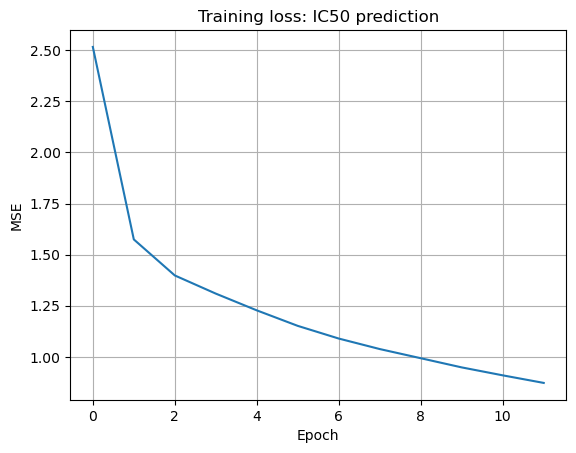

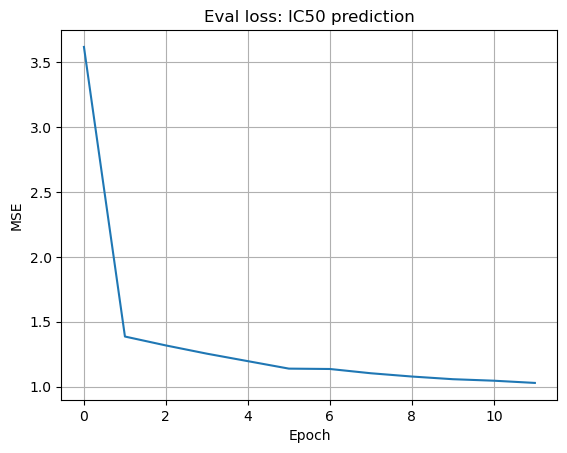

In [12]:
# Plot training and eval loss curves
import matplotlib.pyplot as plt
plt.plot(loss_trn_list)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training loss: IC50 prediction')
plt.grid()
plt.show()
plt.plot(loss_eval_list)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Eval loss: IC50 prediction')
plt.grid()
plt.show()

In [17]:
# Saving the model weights
torch.save(m.cpu().eval().state_dict(), "drug_resp_model_gdsc1.pt")
m.cuda()


PersonalizedDrugResModel(
  (emb): Embedding(50, 64)
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=16, bias=True)
  (lin3): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.75, inplace=False)
  (dropoutSm): Dropout(p=0.1, inplace=False)
  (layernormSmiles): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (layernormRNA): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (mRNAProjLayer1): Linear(in_features=17737, out_features=512, bias=True)
  (mRNAProjLayer2): Linear(in_features=512, out_features=1024, bias=True)
  (FinalLayer1): Linear(in_features=2048, out_features=128, bias=True)
  (FinalLayer2): Linear(in_features=128, out_features=64, bias=True)
  (FinalLayer3): Linear(in_features=64, out_features=32, bias=True)
  (FinalLayer4): Linear(in_features=32, out_features=1, bias=True)
)

(165, 5)
(165, 6)
165 <class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 205.99it/s]


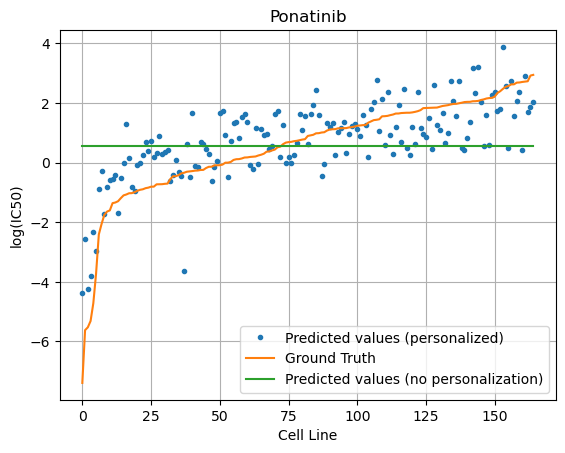

(187, 5)
(187, 6)
187 <class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 317.49it/s]


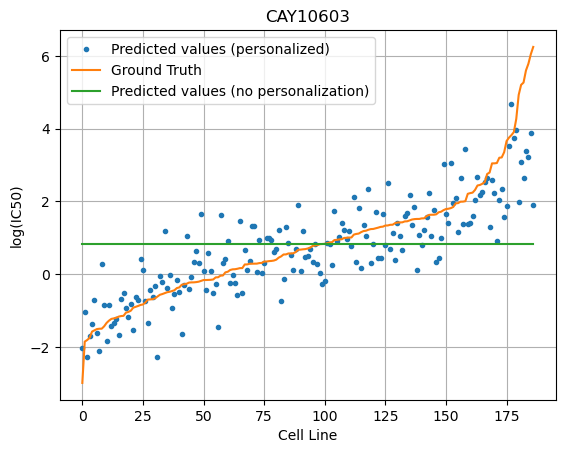

(164, 5)
(164, 6)
164 <class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 311.79it/s]


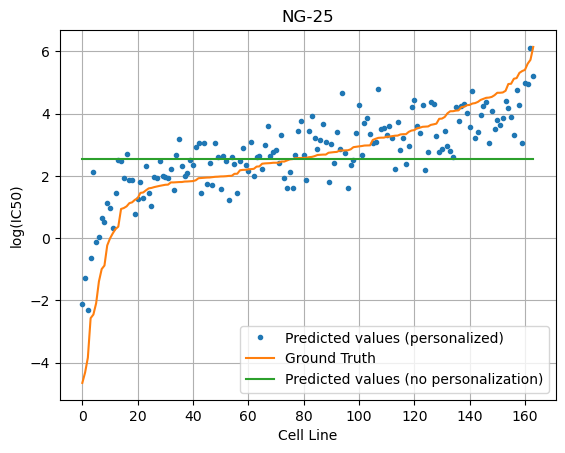

(182, 5)
(182, 6)
182 <class 'list'>


100%|███████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 561.73it/s]


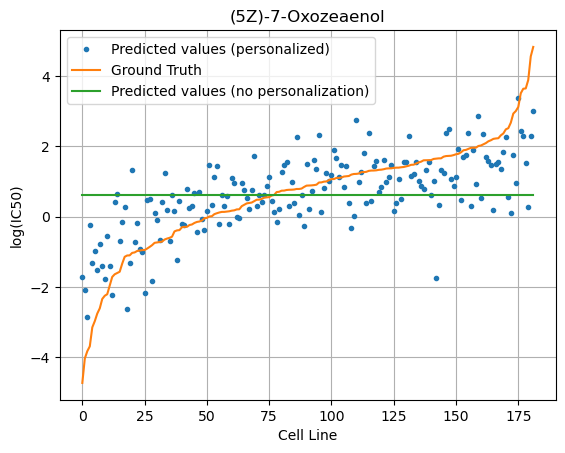

In [18]:
# Lets check how good the models IC50 predictions are
import matplotlib.pyplot as plt
df = split['test']
#print(df.head(1000))
df_eval2=df
d_list = list(set(df_eval2['Drug_ID']))
# Lets check for these drugs across cell lines
d_list = ['Ponatinib', 'CAY10603', 'NG-25', '(5Z)-7-Oxozeaenol']
for d in d_list:
    df_eval2=df
    df_eval2 = df_eval2[df_eval2['Drug_ID'] ==d] # Erlotinib  Bosutinib Crizotinib Pazopanib Tamoxifen Cisplatin Sorafenib Dasatinib
    print(df_eval2.shape)

    df_eval2['Len'] = df_eval2['Drug'].apply(lambda x: len(list(x)))
    # Drop rows where the length of the smiles string is longer than 250
    df_eval2 = df_eval2[df_eval2['Len'] <= seq_len-8]
    print(df_eval2.shape)
    eval_data2 = DrugRespDataset(list(df_eval2['Drug']),list(df_eval2['Cell Line']), list(df_eval2['Y']), vocab, randomize=False, seq_len=seq_len)
    eval_sampler2 = SequentialSampler(eval_data2)
    eval_batch_size=16
    eval_dataloader2 = DataLoader(eval_data2, sampler=eval_sampler2, batch_size=1, drop_last=True) 
    output_array=[]
    target_array=[]
    m.eval()
    for idx, (smiles, mRNA, target) in enumerate(tqdm(eval_dataloader2)):
        with torch.no_grad():
            smiles=smiles.cuda()
            target=target.cuda()
            mRNA = mRNA.cuda().float()
            output = m(smiles, mRNA)
            output= output.squeeze()
            output_array.append(output.cpu().detach().item())
            target_array.append(target.cpu().detach().item())
    plt.figure()
    a = np.array([10, 50, 40, 20, 30])
    output_array = np.array(output_array)
    target_array =np.array(target_array)
    perm = np.argsort((target_array))
    plt.plot(output_array[perm],'.')
    plt.plot(target_array[perm])
    plt.plot(np.mean(target_array)*np.ones(len(target_array)))
    plt.xlabel('Cell Line')
    plt.ylabel('log(IC50)')
    plt.title(d)
    plt.grid()

    plt.legend(['Predicted values (personalized)','Ground Truth','Predicted values (no personalization)'])

    plt.show()